In [1]:
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import keras.backend as K
import tensorflow as tf
from keras import initializers, layers
import fashion_mnist as fashion
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import argparse
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image

Using TensorFlow backend.


## Elements of Capsule Layers

Definitions will emerge here for all parts of Capsule Layer

- Class Length
- Class Mask
- Squashing Function
- Class Capsule Layer

In [2]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [3]:
class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])

In [4]:
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [5]:
class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transform matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """ 
        # Begin: inputs_hat computation V1 ---------------------------------------------------------------------#
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # w_tiled.shape = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        # End: inputs_hat computation V1 ---------------------------------------------------------------------#
        """

        # Begin: inputs_hat computation V2 ---------------------------------------------------------------------#
        # Compute `inputs * W` by scanning inputs_tiled on dimension 0. This is faster but requires Tensorflow.
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))
        # End: inputs_hat computation V2 ---------------------------------------------------------------------#
        """
        # Begin: routing algorithm V1, dynamic ------------------------------------------------------------#
        def body(i, b, outputs):
            c = tf.nn.softmax(b, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))
            if i != 1:
                b = b + K.sum(inputs_hat * outputs, -1, keepdims=True)
            return [i-1, b, outputs]
        cond = lambda i, b, inputs_hat: i > 0
        loop_vars = [K.constant(self.num_routing), self.bias, K.sum(inputs_hat, 1, keepdims=True)]
        shape_invariants = [tf.TensorShape([]),
                            tf.TensorShape([None, self.input_num_capsule, self.num_capsule, 1, 1]),
                            tf.TensorShape([None, 1, self.num_capsule, 1, self.dim_vector])]
        _, _, outputs = tf.while_loop(cond, body, loop_vars, shape_invariants)
        # End: routing algorithm V1, dynamic ------------------------------------------------------------#
        """

        # Begin: routing algorithm V2, static -----------------------------------------------------------#
        # Routing algorithm V2. Use iteration. V2 and V1 both work without much difference on performance
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging
        # End: routing algorithm V2, static ------------------------------------------------------------#

        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])

In [6]:
def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

##  Capsule Network Section

More details will emerge here on definition, choices, architecture and eventual code explanations.

- Function Convolutional Block
- Two versions of CapsNet (details to come later)
- Function Margin Loss
- Function to Train and to Test

In [7]:
def CapsNet(input_shape, n_class, num_routing):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=16, num_routing=num_routing, name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='out_caps')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.
    x_recon = layers.Dense(512, activation='relu')(masked)
    x_recon = layers.Dense(1024, activation='relu')(x_recon)
    x_recon = layers.Dense(np.prod(input_shape), activation='sigmoid')(x_recon)
    x_recon = layers.Reshape(target_shape=input_shape, name='out_recon')(x_recon)

    # two-input-two-output keras Model
    return models.Model([x, y], [out_caps, x_recon])

In [8]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 20, 20, 256)   20992       input_1[0][0]                    
____________________________________________________________________________________________________
primarycap_conv2d (Conv2D)       (None, 6, 6, 256)     5308672     conv1[0][0]                      
____________________________________________________________________________________________________
primarycap_reshape (Reshape)     (None, 1152, 8)       0           primarycap_conv2d[0][0]          
___________________________________________________________________________________________

468/468 [==============================] - 562s - loss: 0.0927 - out_caps_loss: 0.0824 - out_recon_loss: 0.0263 - out_caps_acc: 0.8900 - val_loss: 0.0930 - val_out_caps_loss: 0.0827 - val_out_recon_loss: 0.0262 - val_out_caps_acc: 0.8876
Epoch 12/200
468/468 [==============================] - 562s - loss: 0.0906 - out_caps_loss: 0.0805 - out_recon_loss: 0.0257 - out_caps_acc: 0.8925 - val_loss: 0.0860 - val_out_caps_loss: 0.0763 - val_out_recon_loss: 0.0247 - val_out_caps_acc: 0.8946
Epoch 13/200
468/468 [==============================] - 562s - loss: 0.0879 - out_caps_loss: 0.0780 - out_recon_loss: 0.0252 - out_caps_acc: 0.8962 - val_loss: 0.0849 - val_out_caps_loss: 0.0753 - val_out_recon_loss: 0.0244 - val_out_caps_acc: 0.8968
Epoch 14/200
468/468 [==============================] - 562s - loss: 0.0864 - out_caps_loss: 0.0766 - out_recon_loss: 0.0248 - out_caps_acc: 0.8984 - val_loss: 0.0841 - val_out_caps_loss: 0.0743 - val_out_recon_loss: 0.0248 - val_out_caps_acc: 0.9041
Epoch 15/

468/468 [==============================] - 562s - loss: 0.0679 - out_caps_loss: 0.0595 - out_recon_loss: 0.0214 - out_caps_acc: 0.9207 - val_loss: 0.0731 - val_out_caps_loss: 0.0647 - val_out_recon_loss: 0.0214 - val_out_caps_acc: 0.9131
Epoch 29/200
468/468 [==============================] - 562s - loss: 0.0663 - out_caps_loss: 0.0579 - out_recon_loss: 0.0213 - out_caps_acc: 0.9235 - val_loss: 0.0690 - val_out_caps_loss: 0.0608 - val_out_recon_loss: 0.0211 - val_out_caps_acc: 0.9180
Epoch 30/200
468/468 [==============================] - 562s - loss: 0.0660 - out_caps_loss: 0.0577 - out_recon_loss: 0.0211 - out_caps_acc: 0.9234 - val_loss: 0.0718 - val_out_caps_loss: 0.0637 - val_out_recon_loss: 0.0209 - val_out_caps_acc: 0.9157
Epoch 31/200
468/468 [==============================] - 562s - loss: 0.0650 - out_caps_loss: 0.0568 - out_recon_loss: 0.0209 - out_caps_acc: 0.9247 - val_loss: 0.0712 - val_out_caps_loss: 0.0630 - val_out_recon_loss: 0.0210 - val_out_caps_acc: 0.9149
Epoch 32/

468/468 [==============================] - 562s - loss: 0.0559 - out_caps_loss: 0.0482 - out_recon_loss: 0.0197 - out_caps_acc: 0.9356 - val_loss: 0.0635 - val_out_caps_loss: 0.0558 - val_out_recon_loss: 0.0197 - val_out_caps_acc: 0.9242
Epoch 47/200
468/468 [==============================] - 562s - loss: 0.0557 - out_caps_loss: 0.0480 - out_recon_loss: 0.0196 - out_caps_acc: 0.9371 - val_loss: 0.0644 - val_out_caps_loss: 0.0567 - val_out_recon_loss: 0.0197 - val_out_caps_acc: 0.9221
Epoch 48/200
468/468 [==============================] - 562s - loss: 0.0558 - out_caps_loss: 0.0481 - out_recon_loss: 0.0196 - out_caps_acc: 0.9365 - val_loss: 0.0633 - val_out_caps_loss: 0.0556 - val_out_recon_loss: 0.0196 - val_out_caps_acc: 0.9249
Epoch 49/200
468/468 [==============================] - 562s - loss: 0.0547 - out_caps_loss: 0.0470 - out_recon_loss: 0.0196 - out_caps_acc: 0.9373 - val_loss: 0.0636 - val_out_caps_loss: 0.0559 - val_out_recon_loss: 0.0196 - val_out_caps_acc: 0.9262
Epoch 50/

468/468 [==============================] - 562s - loss: 0.0510 - out_caps_loss: 0.0436 - out_recon_loss: 0.0191 - out_caps_acc: 0.9422 - val_loss: 0.0612 - val_out_caps_loss: 0.0537 - val_out_recon_loss: 0.0193 - val_out_caps_acc: 0.9285
Epoch 65/200
468/468 [==============================] - 562s - loss: 0.0502 - out_caps_loss: 0.0427 - out_recon_loss: 0.0191 - out_caps_acc: 0.9436 - val_loss: 0.0614 - val_out_caps_loss: 0.0538 - val_out_recon_loss: 0.0193 - val_out_caps_acc: 0.9270
Epoch 66/200
468/468 [==============================] - 562s - loss: 0.0508 - out_caps_loss: 0.0434 - out_recon_loss: 0.0191 - out_caps_acc: 0.9434 - val_loss: 0.0617 - val_out_caps_loss: 0.0542 - val_out_recon_loss: 0.0193 - val_out_caps_acc: 0.9279
Epoch 67/200
468/468 [==============================] - 562s - loss: 0.0508 - out_caps_loss: 0.0433 - out_recon_loss: 0.0191 - out_caps_acc: 0.9436 - val_loss: 0.0612 - val_out_caps_loss: 0.0536 - val_out_recon_loss: 0.0192 - val_out_caps_acc: 0.9279
Epoch 68/

468/468 [==============================] - 591s - loss: 0.0493 - out_caps_loss: 0.0418 - out_recon_loss: 0.0189 - out_caps_acc: 0.9444 - val_loss: 0.0600 - val_out_caps_loss: 0.0525 - val_out_recon_loss: 0.0191 - val_out_caps_acc: 0.9284
Epoch 83/200
468/468 [==============================] - 591s - loss: 0.0488 - out_caps_loss: 0.0414 - out_recon_loss: 0.0189 - out_caps_acc: 0.9454 - val_loss: 0.0604 - val_out_caps_loss: 0.0529 - val_out_recon_loss: 0.0191 - val_out_caps_acc: 0.9270
Epoch 84/200
468/468 [==============================] - 591s - loss: 0.0486 - out_caps_loss: 0.0412 - out_recon_loss: 0.0189 - out_caps_acc: 0.9461 - val_loss: 0.0603 - val_out_caps_loss: 0.0528 - val_out_recon_loss: 0.0191 - val_out_caps_acc: 0.9282
Epoch 85/200
468/468 [==============================] - 591s - loss: 0.0485 - out_caps_loss: 0.0411 - out_recon_loss: 0.0189 - out_caps_acc: 0.9468 - val_loss: 0.0602 - val_out_caps_loss: 0.0527 - val_out_recon_loss: 0.0191 - val_out_caps_acc: 0.9285
Epoch 86/

468/468 [==============================] - 607s - loss: 0.0478 - out_caps_loss: 0.0404 - out_recon_loss: 0.0188 - out_caps_acc: 0.9474 - val_loss: 0.0603 - val_out_caps_loss: 0.0528 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9292
Epoch 102/200
468/468 [==============================] - 605s - loss: 0.0476 - out_caps_loss: 0.0402 - out_recon_loss: 0.0189 - out_caps_acc: 0.9476 - val_loss: 0.0600 - val_out_caps_loss: 0.0526 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9281
Epoch 103/200
468/468 [==============================] - 599s - loss: 0.0481 - out_caps_loss: 0.0407 - out_recon_loss: 0.0189 - out_caps_acc: 0.9453 - val_loss: 0.0599 - val_out_caps_loss: 0.0524 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9291
Epoch 104/200
468/468 [==============================] - 598s - loss: 0.0480 - out_caps_loss: 0.0406 - out_recon_loss: 0.0188 - out_caps_acc: 0.9468 - val_loss: 0.0600 - val_out_caps_loss: 0.0525 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9281
Epoch 

468/468 [==============================] - 597s - loss: 0.0469 - out_caps_loss: 0.0396 - out_recon_loss: 0.0188 - out_caps_acc: 0.9483 - val_loss: 0.0599 - val_out_caps_loss: 0.0525 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9284
Epoch 120/200
468/468 [==============================] - 596s - loss: 0.0481 - out_caps_loss: 0.0408 - out_recon_loss: 0.0188 - out_caps_acc: 0.9472 - val_loss: 0.0599 - val_out_caps_loss: 0.0524 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9291
Epoch 121/200
468/468 [==============================] - 598s - loss: 0.0472 - out_caps_loss: 0.0399 - out_recon_loss: 0.0188 - out_caps_acc: 0.9480 - val_loss: 0.0599 - val_out_caps_loss: 0.0524 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9294
Epoch 122/200
468/468 [==============================] - 596s - loss: 0.0473 - out_caps_loss: 0.0399 - out_recon_loss: 0.0188 - out_caps_acc: 0.9477 - val_loss: 0.0599 - val_out_caps_loss: 0.0524 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9298
Epoch 

468/468 [==============================] - 601s - loss: 0.0474 - out_caps_loss: 0.0400 - out_recon_loss: 0.0188 - out_caps_acc: 0.9481 - val_loss: 0.0598 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9290
Epoch 139/200
468/468 [==============================] - 601s - loss: 0.0473 - out_caps_loss: 0.0400 - out_recon_loss: 0.0188 - out_caps_acc: 0.9480 - val_loss: 0.0598 - val_out_caps_loss: 0.0524 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9290
Epoch 140/200
468/468 [==============================] - 601s - loss: 0.0473 - out_caps_loss: 0.0399 - out_recon_loss: 0.0188 - out_caps_acc: 0.9482 - val_loss: 0.0598 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9288
Epoch 141/200
468/468 [==============================] - 601s - loss: 0.0476 - out_caps_loss: 0.0402 - out_recon_loss: 0.0188 - out_caps_acc: 0.9476 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9286
Epoch 

468/468 [==============================] - 596s - loss: 0.0474 - out_caps_loss: 0.0400 - out_recon_loss: 0.0188 - out_caps_acc: 0.9486 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9290
Epoch 158/200
468/468 [==============================] - 595s - loss: 0.0472 - out_caps_loss: 0.0398 - out_recon_loss: 0.0188 - out_caps_acc: 0.9480 - val_loss: 0.0598 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9292
Epoch 159/200
468/468 [==============================] - 596s - loss: 0.0481 - out_caps_loss: 0.0407 - out_recon_loss: 0.0188 - out_caps_acc: 0.9463 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9290
Epoch 160/200
468/468 [==============================] - 594s - loss: 0.0466 - out_caps_loss: 0.0392 - out_recon_loss: 0.0187 - out_caps_acc: 0.9493 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9289
Epoch 

468/468 [==============================] - 596s - loss: 0.0465 - out_caps_loss: 0.0392 - out_recon_loss: 0.0188 - out_caps_acc: 0.9491 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9288
Epoch 177/200
468/468 [==============================] - 595s - loss: 0.0473 - out_caps_loss: 0.0400 - out_recon_loss: 0.0188 - out_caps_acc: 0.9476 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9289
Epoch 178/200
468/468 [==============================] - 595s - loss: 0.0475 - out_caps_loss: 0.0401 - out_recon_loss: 0.0188 - out_caps_acc: 0.9481 - val_loss: 0.0598 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9287
Epoch 179/200
468/468 [==============================] - 595s - loss: 0.0474 - out_caps_loss: 0.0400 - out_recon_loss: 0.0188 - out_caps_acc: 0.9484 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9288
Epoch 

468/468 [==============================] - 595s - loss: 0.0473 - out_caps_loss: 0.0399 - out_recon_loss: 0.0188 - out_caps_acc: 0.9484 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9289
Epoch 196/200
468/468 [==============================] - 598s - loss: 0.0470 - out_caps_loss: 0.0397 - out_recon_loss: 0.0188 - out_caps_acc: 0.9486 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9292
Epoch 197/200
468/468 [==============================] - 599s - loss: 0.0474 - out_caps_loss: 0.0401 - out_recon_loss: 0.0188 - out_caps_acc: 0.9476 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9291
Epoch 198/200
468/468 [==============================] - 598s - loss: 0.0472 - out_caps_loss: 0.0398 - out_recon_loss: 0.0188 - out_caps_acc: 0.9489 - val_loss: 0.0597 - val_out_caps_loss: 0.0523 - val_out_recon_loss: 0.0190 - val_out_caps_acc: 0.9290
Epoch 

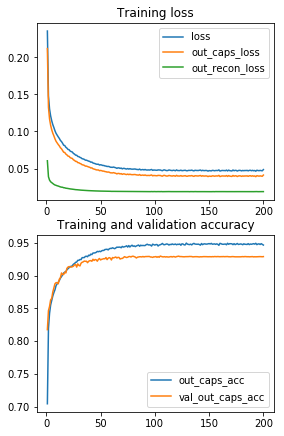

In [9]:
def train(model, data):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_test, y_test) = data

    # callbacks
    log = callbacks.CSVLogger(save_dir + '/log.csv')
    tb = callbacks.TensorBoard(log_dir=save_dir + '/tensorboard-logs',
                               batch_size=batch_size, histogram_freq=debug)
    checkpoint = callbacks.ModelCheckpoint(save_dir + '/weights-{epoch:02d}.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: lr * (0.95 ** epoch))

    # compile the model
    model.compile(optimizer=optimizers.Adam(lr=lr),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., lam_recon],
                  metrics={'out_caps': 'accuracy'})

    """
    # Training without data augmentation:
    model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
              validation_data=[[x_test, y_test], [y_test, x_test]], callbacks=[log, tb, checkpoint, lr_decay])
    """

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction,
                                           horizontal_flip=True)  # shift up to 2 pixel for MNIST
        generator = train_datagen.flow(x, y, batch_size=batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, batch_size, shift_fraction),
                        steps_per_epoch=int(y_train.shape[0] / batch_size),
                        epochs=epochs,
                        validation_data=[[x_test, y_test], [y_test, x_test]],
                        callbacks=[log, tb, checkpoint, lr_decay])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights(save_dir + '/trained_model.h5')
    print('Trained model saved to \'%s/trained_model.h5\'' % save_dir)

    from utils import plot_log
    plot_log(save_dir + '/log.csv', show=True)

    return model

# Define Test function

def test(model, data):
    x_test, y_test = data
    y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
    print('-'*50)
    print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])
    img = combine_images(np.concatenate([x_test[:50],x_recon[:50]]))
    image = img * 255
    Image.fromarray(image.astype(np.uint8)).save("real_and_recon.png")
    print()
    print('Reconstructed images are saved to ./real_and_recon.png')
    print('-'*50)
    plt.imshow(plt.imread("real_and_recon.png", ))
    plt.show()
    
# Define load Fashion MNIST data Fuction
def load_mnist():
    # the data, shuffled and split between train and test sets
    (x_train, y_train), (x_test, y_test) = fashion.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)

# hyperparameters

batch_size     = 128
epochs         = 200
lam_recon      = 0.392  # 784 * 0.0005, paper uses sum of SE, here uses MSE
num_routing    = 3      # num_routing should > 0
shift_fraction = 0.1
debug          = 0      # debug>0 will save weights by TensorBoard
save_dir       ='./result'
is_training    = 1
weights        = None
lr             = 0.001

    
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# load data
(x_train, y_train), (x_test, y_test) = load_mnist()

# define model
model = CapsNet(input_shape=[28, 28, 1],
                n_class=len(np.unique(np.argmax(y_train, 1))),
                num_routing=num_routing)
    
model.summary()

    
# train or test
if weights is not None:  # init the model weights with provided one
    model.load_weights(weights)
if is_training:
    train(model=model, data=((x_train, y_train), (x_test, y_test)))
else:  # as long as weights are given, will run testing
    if weights is None:
        print('No weights are provided. Will test using random initialized weights.')
    test(model=model, data=(x_test, y_test))